## [Advanced dynamic seq2seq model](https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/2-seq2seq-advanced.ipynb)
Now the Encoder is bidirectional and Decoders is implemented using tf.nn.raw_rnn. It feeds previously generated tokens during training as inputs, instead of target sequence.

In [27]:
import numpy as np
import tensorflow as tf
import helpers

In [12]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = 20*2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

# We implement decoder with tf.nn.raw_rnn and will construct decoder_inputs step by step in the loop.
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

### Embeddings

In [8]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

### Encoder

In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [10]:
(encoder_fw_outputs,encoder_bw_outputs),(encoder_fw_final_state,encoder_bw_final_state) = tf.nn.bidirectional_dynamic_rnn(
                                                                                                cell_fw = encoder_cell,
                                                                                                cell_bw = encoder_cell,
                                                                                                inputs = encoder_inputs_embedded,
                                                                                                sequence_length=encoder_inputs_length,
                                                                                                dtype=tf.float32, time_major=True)

In [11]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [13]:
encoder_outputs = tf.concat(
    (encoder_fw_outputs, encoder_bw_outputs), 1)
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

### Decoder

In [15]:
decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

we need to decide how far to run decoder. There are several options for stopping criteria:
* Stop after specified number of unrolling steps
* Stop after model produced

In [16]:
decoder_lengths = encoder_inputs_length + 3

### Output projection
Decoder will contain manually specified by us transition step:
> output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)

In [17]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

### Decoder via tf.nn.raw_rnn

In [18]:
eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Remember that standard tf.nn.dynamic_rnn requires all inputs (t, ..., t+n) be passed in advance as a single tensor. 

What if we want to implement more complex mechanic like when we want decoder to receive previously generated tokens as input at every timestamp (instead of lagged target sequence)?

tf.nn.raw_rnn is a way to solve this problem.

Main part of specifying RNN with tf.nn.raw_rnn is loop transition function. It defines inputs of step t given outputs and state of step t-1.

Loop transition function is a mapping 
> (time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state). 

It is called before RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is None (except time).

Loop initial state is function of only encoder_final_state and embeddings:

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function such that previously generated token (as judged in greedy manner by argmax over output projection) is passed as next input.

In [20]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [22]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [23]:
help(tf.nn.raw_rnn)

Help on function raw_rnn in module tensorflow.python.ops.rnn:

raw_rnn(cell, loop_fn, parallel_iterations=None, swap_memory=False, scope=None)
    Creates an `RNN` specified by RNNCell `cell` and loop function `loop_fn`.
    
    **NOTE: This method is still in testing, and the API may change.**
    
    This function is a more primitive version of `dynamic_rnn` that provides
    more direct access to the inputs each iteration.  It also provides more
    control over when to start and finish reading the sequence, and
    what to emit for the output.
    
    For example, it can be used to implement the dynamic decoder of a seq2seq
    model.
    
    Instead of working with `Tensor` objects, most operations work with
    `TensorArray` objects directly.
    
    The operation of `raw_rnn`, in pseudo-code, is basically the following:
    
    ```python
    time = tf.constant(0, dtype=tf.int32)
    (finished, next_input, initial_state, _, loop_state) = loop_fn(
        time=time, cell_out

In [24]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

In [25]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

### Train

In [28]:
batch_size = 100
batches = helpers.random_sequences(length_from=3, length_to=8,
                                       vocab_lower=2, vocab_upper=10,
                                       batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 8, 3, 3]
[6, 8, 3]
[4, 9, 6]
[6, 8, 9, 7]
[9, 7, 8, 4, 9]
[7, 9, 6, 4, 9, 3, 7, 8]
[9, 9, 2, 3, 9, 6, 6]
[9, 4, 8, 7, 6, 7]
[3, 6, 2, 8, 2, 3, 5]
[5, 5, 9]


In [29]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_track = []
    max_batches = 3001
    batches_in_epoch = 1000

    try:
        for batch in range(max_batches):
            fd = next_feed()
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)

            if batch == 0 or batch % batches_in_epoch == 0:
                print('batch {}'.format(batch))
                print('  minibatch loss: {}'.format(sess.run(loss, fd)))
                predict_ = sess.run(decoder_prediction, fd)
                for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    print('    input     > {}'.format(inp))
                    print('    predicted > {}'.format(pred))
                    if i >= 2:
                        break
                print()

    except KeyboardInterrupt:
        print('training interrupted')

batch 0
  minibatch loss: 2.3040153980255127
  sample 1:
    input     > [6 7 4 4 4 6 6 2]
    predicted > [6 6 6 6 6 6 0 3 3 0 3]
  sample 2:
    input     > [8 7 6 4 8 0 0 0]
    predicted > [3 1 1 6 1 6 1 6 0 0 0]
  sample 3:
    input     > [6 4 5 8 8 5 5 0]
    predicted > [6 6 6 6 6 0 3 3 0 1 0]

batch 1000
  minibatch loss: 0.4616509974002838
  sample 1:
    input     > [5 5 2 3 7 0 0 0]
    predicted > [5 5 2 3 7 1 0 0 0 0 0]
  sample 2:
    input     > [6 5 7 6 6 0 0 0]
    predicted > [6 5 7 6 6 1 0 0 0 0 0]
  sample 3:
    input     > [2 4 5 7 7 8 0 0]
    predicted > [2 4 7 7 7 8 1 0 0 0 0]

batch 2000
  minibatch loss: 0.19868206977844238
  sample 1:
    input     > [7 3 8 4 6 0 0 0]
    predicted > [7 3 8 4 6 1 0 0 0 0 0]
  sample 2:
    input     > [6 4 2 3 2 9 0 0]
    predicted > [6 4 2 3 2 9 1 0 0 0 0]
  sample 3:
    input     > [4 3 9 3 5 4 0 0]
    predicted > [4 3 9 3 5 4 1 0 0 0 0]

batch 3000
  minibatch loss: 0.08551758527755737
  sample 1:
    input     > [6 9

loss 0.0914 after 300100 examples (batch_size=100)


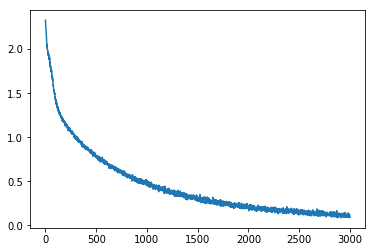

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))